In [47]:
from pathlib import Path
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import yaml
import random
import shutil

from bearfacedetection.xml_parser import load_xml

In [2]:
def filepath_to_image(filepath: Path):
    image = cv2.imread(str(filepath))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def to_boolean_mask(black_white_image):
    return np.all(black_white_image == [255, 255, 255], axis=2)

def load_image(image_data: dict):
    image_filepath = image_data["filepath"]
    image = cv2.imread(str(image_filepath))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(image):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis('on')
    plt.show()

In [3]:
base_path = Path('../../data/01_raw/BearID/')
label_path = base_path / 'images_train_without_bc.xml'
xml_data = load_xml(base_path=base_path, filepath=label_path)

In [4]:
idx = 146
image_data = xml_data["images"][idx]
image_filepath = image_data["filepath"]
image = load_image(image_data)

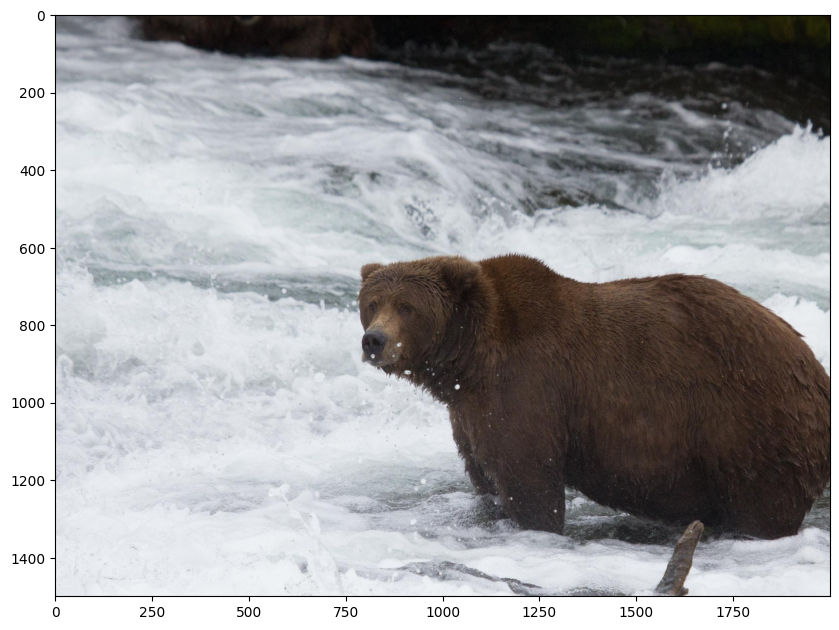

In [5]:
show_image(image)

In [6]:
from bearfacedetection.yolov8_txt_format import to_yolov8_bbox, to_yolov8_point

In [10]:
image_data["size"]

{'width': 2000, 'height': 1500}

In [24]:
image_size = image_data["size"]
bbox = image_data["bboxes"][0]
parts = bbox["parts"]
normalized_bbox = to_yolov8_bbox(bbox, image_size)

In [17]:
normalized_point_nose = to_yolov8_point(bbox["parts"]["nose"]["x"], bbox["parts"]["nose"]["y"], image_size)
normalized_point_leye = to_yolov8_point(bbox["parts"]["leye"]["x"], bbox["parts"]["leye"]["y"], image_size)
normalized_point_reye = to_yolov8_point(bbox["parts"]["reye"]["x"], bbox["parts"]["reye"]["y"], image_size)

In [27]:
def to_yolov8_txt_format(bbox, nose_point: tuple[int, int], leye_point: tuple[int, int], reye_point: tuple[int, int], size: dict, keypoints_order: list=["nose", "leye", "reye"]) -> str:
    """
    Following the doc from here: https://docs.ultralytics.com/datasets/pose/#ultralytics-yolo-format 
    """
    class_index = 0
    normalized_bbox = to_yolov8_bbox(bbox, size)
    normalized_point_nose = to_yolov8_point(nose_point[0], nose_point[1], size)
    normalized_point_leye = to_yolov8_point(leye_point[0], leye_point[1], size)
    normalized_point_reye = to_yolov8_point(reye_point[0], reye_point[1], size)
    keypoints = {"nose": normalized_point_nose, "leye": normalized_point_leye, "reye": normalized_point_reye}
    ordered_keypoints = [keypoints[label] for label in keypoints_order]
    keypoints_str = " ".join([f"{kp['x']} {kp['y']}" for kp in ordered_keypoints])
    return f"{class_index} {normalized_bbox['center_x']} {normalized_bbox['center_y']} {normalized_bbox['w']} {normalized_bbox['h']} {keypoints_str}"


In [20]:
to_yolov8_bbox(bbox, image_size)

{'center_x': 0.422, 'center_y': 0.526, 'w': 0.1, 'h': 0.13333333333333333}

In [23]:
def part_to_point(part):
    return part["x"], part["y"]

In [51]:
keypoints_order = ["nose", "leye", "reye"]
flip_idx = [0, 2, 1]
dim = 2

number_keypoints = len(keypoints_order)
kpt_shape = [number_keypoints, dim]

to_yolov8_txt_format(bbox=bbox, nose_point=part_to_point(parts["nose"]), leye_point=part_to_point(parts["leye"]), reye_point=part_to_point(parts["reye"]), size=image_size)

'0 0.422 0.526 0.1 0.13333333333333333 0.406 0.5533333333333333 0.456 0.5073333333333333 0.4065 0.504'

In [52]:
class MyDumper(yaml.Dumper):
    def increase_indent(self, flow=False, indentless=False):
        return super(MyDumper, self).increase_indent(flow, False)


def write_data_yaml(path: Path, kpt_shape: list, flip_idx: list) -> None:
    """Writes the `data.yaml` file necessary for YOLOv8 training at `path`
    location."""
    data = {
        "train": "./train/images",
        "val": "./val/images",
        "nc": 1,
        "names": ["bearface"],
        "kpt_shape": kpt_shape,
        "flip_idx": flip_idx,
    }
    with open(path / "data.yaml", "w") as f:
        yaml.dump(data, f, Dumper=MyDumper, default_flow_style=False, sort_keys=False)

In [53]:
output_dir = Path("../../data/05_model_input/bearfacelandmarkdetection/first_test/")

In [54]:
output_dir.exists()

True

In [55]:
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir / "train" / "images", exist_ok=True)
os.makedirs(output_dir / "train" / "labels", exist_ok=True)
os.makedirs(output_dir / "val" / "images", exist_ok=True)
os.makedirs(output_dir / "val" / "labels", exist_ok=True)

In [56]:
write_data_yaml(output_dir, kpt_shape=kpt_shape, flip_idx=flip_idx)

In [57]:
shutil.copy(image_data["filepath"], output_dir / "train" / "images" / image_data["filepath"].name)

PosixPath('../../data/05_model_input/bearfacelandmarkdetection/first_test/train/images/289-7.jpg')

In [58]:
label_content = to_yolov8_txt_format(bbox=bbox, nose_point=part_to_point(parts["nose"]), leye_point=part_to_point(parts["leye"]), reye_point=part_to_point(parts["reye"]), size=image_size)
with open(output_dir / "train" / "labels" / f'{image_data["filepath"].stem}.txt', "w") as f:
    f.write(label_content)